In [1]:
import pandas as pd
import numpy as np
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.metrics import f1_score, classification_report
import matplotlib.pyplot as plt
from sklearn.metrics import ConfusionMatrixDisplay, roc_curve, auc
import shap


Matplotlib is building the font cache; this may take a moment.
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
gemini_features = [
    "AGEP_A",          # age (years, 18‑85 top‑coded)
    "SEX_A",           # sex
    "HISPALLP_A",      # combined race / ethnicity
    "EDUCP_A",         # education level
    "BMICAT_A",        # BMI category
    "SMKCIGST_A",      # smoking status
    "HYPEV_A",         # ever hypertension
    "CHLEV_A",         # ever high cholesterol
    "DIBEV_A",         # ever diabetes
    "PHSTAT_A",        # self‑rated health
    "DEPEV_A",         # ever depression
    "COPDEV_A",        # ever COPD / chronic bronchitis / emphysema
    "STREV_A"          # ever stroke
]

target_columns = ['CHDEV_A', 'ANGEV_A', 'MIEV_A']

data_df = pd.read_csv('adult23.csv')
data_df = data_df[gemini_features + target_columns]

data_df

,AGEP_A,SEX_A,HISPALLP_A,EDUCP_A,BMICAT_A,SMKCIGST_A,HYPEV_A,CHLEV_A,DIBEV_A,PHSTAT_A,DEPEV_A,COPDEV_A,STREV_A,CHDEV_A,ANGEV_A,MIEV_A
0,67,1,3,1,3,4,1,1,2,5,1,2,1,2,2,2
1,73,1,2,8,3,1,1,2,1,3,2,2,2,1,2,1
2,48,1,3,5,4,4,2,2,2,1,2,2,2,2,2,2
3,42,2,2,9,3,3,2,2,2,1,2,2,2,2,2,2
4,50,2,2,7,2,4,2,2,2,2,2,2,2,2,2,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
29517,77,2,2,5,4,3,1,1,2,3,1,1,2,2,2,2
29518,59,2,2,7,3,4,2,1,2,1,1,2,2,2,2,2
29519,66,1,2,8,4,4,2,2,2,3,2,2,2,2,2,2
29520,53,2,2,7,3,1,1,2,2,2,2,2,2,2,2,2


In [3]:
def map_codes(col, mapping, unknown="Unknown"):
    """Map numeric codes to text; keep <NA>; anything else → 'Unknown'."""
    return (
        col.replace(mapping)          # map known codes
           .mask(col.isna(), pd.NA)   # preserve genuine <NA>
           .fillna(unknown)           # leftover unusual codes
           .astype("string")
    )

data_df["SEX_A"] = map_codes(data_df["SEX_A"], {1: "Male",  2: "Female"})

data_df["HISPALLP_A"] = map_codes(data_df["HISPALLP_A"],{
    1: "Hispanic", 2: "White‑NH", 3: "Black‑NH", 4: "Asian‑NH",
    5: "AIAN‑NH",  6: "AIAN+Other", 7: "Other"})

data_df["EDUCP_A"] = map_codes(data_df["EDUCP_A"], {
    0: "None/KG", 1: "1–11th", 2: "12th/no dip", 3: "GED",
    4: "HS Grad", 5: "Some College", 6: "Assoc‑Occ/Voc",
    7: "Assoc‑Acad", 8: "Bachelor", 9: "Master", 10: "Prof/PhD"})

data_df["BMICAT_A"] = map_codes(data_df["BMICAT_A"], {
    1: "Under", 2: "Normal", 3: "Over", 4: "Obese", 5: "ExtObese"})

data_df["SMKCIGST_A"] = map_codes(data_df["SMKCIGST_A"], {
    1: "Every day", 2: "Some days", 3: "Former", 4: "Never"})

data_df["PHSTAT_A"] = map_codes(data_df["PHSTAT_A"], {
    1: "Excellent", 2: "Very good", 3: "Good", 4: "Fair", 5: "Poor"})

binary_variables = ["HYPEV_A", "CHLEV_A", "DIBEV_A", "DEPEV_A", "COPDEV_A", "STREV_A"]

for col in binary_variables:
    data_df[col] = map_codes(data_df[col], {1: "Yes", 2: "No"})


In [4]:
data_df["heart_disease"] = (
    (data_df["CHDEV_A"] == 1) | 
    (data_df["ANGEV_A"] == 1) | 
    (data_df["MIEV_A"] == 1)
).astype(int)

X = data_df.drop(columns=["heart_disease"] + target_columns)
y = data_df["heart_disease"]

# Defining the categorical and numerical columns (just age in this case)
cat_cols = X.columns.tolist()           
cat_cols.remove("AGEP_A")

In [5]:
ohe = OneHotEncoder(
        sparse_output=False,
        handle_unknown="ignore"
      )

ct = ColumnTransformer(
        [("onehot", ohe, cat_cols)],
        remainder="passthrough"
     )

X_encoded = ct.fit_transform(X)

feature_names = (
    ct.named_transformers_["onehot"]
      .get_feature_names_out(cat_cols)
      .tolist() + ["AGEP_A"]
)
X_final = pd.DataFrame(X_encoded, columns=feature_names, index=X.index)

# sanity check – no NA left
assert X_final.isna().sum().sum() == 0, "still missing values!"

In [6]:
X_train, X_test, y_train, y_test = train_test_split(
    X_final, y, test_size=0.20, stratify=y, random_state=42
)
pipe_lr = Pipeline([
    ("scale", StandardScaler(with_mean=False)),
    ("clf", LogisticRegression(max_iter=1000, class_weight="balanced"))
])

param_grid_lr = {
    'clf__C': [0.01, 0.1, 1, 10, 100],
    'clf__penalty': ['l2'],
    'clf__solver': ['liblinear', 'lbfgs'],
    'clf__class_weight': ['balanced']
}

grid_lr = GridSearchCV(pipe_lr, param_grid_lr, scoring='f1', cv=5, n_jobs=-1, verbose=2)
grid_lr.fit(X_train, y_train)
best_lr = grid_lr.best_estimator_
print("Best LR parameters:", grid_lr.best_params_)


Fitting 5 folds for each of 10 candidates, totalling 50 fits
[CV] END clf__C=0.01, clf__class_weight=balanced, clf__penalty=l2, clf__solver=liblinear; total time=   0.1s
[CV] END clf__C=0.01, clf__class_weight=balanced, clf__penalty=l2, clf__solver=liblinear; total time=   0.1s
[CV] END clf__C=0.01, clf__class_weight=balanced, clf__penalty=l2, clf__solver=liblinear; total time=   0.1s
[CV] END clf__C=0.01, clf__class_weight=balanced, clf__penalty=l2, clf__solver=liblinear; total time=   0.1s
[CV] END clf__C=0.01, clf__class_weight=balanced, clf__penalty=l2, clf__solver=liblinear; total time=   0.1s
[CV] END clf__C=0.01, clf__class_weight=balanced, clf__penalty=l2, clf__solver=lbfgs; total time=   0.2s
[CV] END clf__C=0.01, clf__class_weight=balanced, clf__penalty=l2, clf__solver=lbfgs; total time=   0.1s
[CV] END clf__C=0.1, clf__class_weight=balanced, clf__penalty=l2, clf__solver=liblinear; total time=   0.1s
[CV] END clf__C=0.1, clf__class_weight=balanced, clf__penalty=l2, clf__solve

In [7]:
param_grid_rf = {
    'n_estimators': [100, 200],
    'max_depth': [None, 10, 20],
    'min_samples_split': [2, 10],
    'class_weight': ['balanced']
}

grid_rf = GridSearchCV(
    RandomForestClassifier(random_state=42, n_jobs=-1),
    param_grid_rf,
    scoring='f1',
    cv=5,
    n_jobs=-1,
    verbose=2
)
grid_rf.fit(X_train, y_train)
best_rf = grid_rf.best_estimator_
print("Best RF parameters:", grid_rf.best_params_)

Fitting 5 folds for each of 12 candidates, totalling 60 fits
[CV] END class_weight=balanced, max_depth=None, min_samples_split=2, n_estimators=100; total time=   1.0s
[CV] END class_weight=balanced, max_depth=None, min_samples_split=2, n_estimators=100; total time=   1.2s
[CV] END class_weight=balanced, max_depth=None, min_samples_split=2, n_estimators=100; total time=   1.3s
[CV] END class_weight=balanced, max_depth=None, min_samples_split=2, n_estimators=100; total time=   1.3s
[CV] END class_weight=balanced, max_depth=None, min_samples_split=2, n_estimators=100; total time=   1.4s
[CV] END class_weight=balanced, max_depth=None, min_samples_split=10, n_estimators=100; total time=   1.0s
[CV] END class_weight=balanced, max_depth=None, min_samples_split=10, n_estimators=100; total time=   0.9s
[CV] END class_weight=balanced, max_depth=None, min_samples_split=10, n_estimators=100; total time=   1.2s
[CV] END class_weight=balanced, max_depth=None, min_samples_split=2, n_estimators=200; t

In [8]:
param_grid = {
    'n_estimators': [100, 200],
    'max_depth': [3, 5],
    'learning_rate': [0.1, 0.01],
    'scale_pos_weight': [1, (len(y_train) - sum(y_train)) / sum(y_train)]
}

grid_xgb = GridSearchCV(
    estimator=XGBClassifier(
        eval_metric='logloss',
        verbosity=0
    ),
    param_grid=param_grid,
    scoring='f1',
    cv=5,
    n_jobs=-1,
    verbose=2
)
grid_xgb.fit(X_train, y_train)
best_xgb_model = grid_xgb.best_estimator_
print("Best XGBoost Params:", grid_xgb.best_params_)


Fitting 5 folds for each of 16 candidates, totalling 80 fits
[CV] END learning_rate=0.1, max_depth=3, n_estimators=100, scale_pos_weight=1; total time=   0.2s
[CV] END learning_rate=0.1, max_depth=3, n_estimators=100, scale_pos_weight=11.23045054375971; total time=   0.2s
[CV] END learning_rate=0.1, max_depth=3, n_estimators=100, scale_pos_weight=1; total time=   0.3s
[CV] END learning_rate=0.1, max_depth=3, n_estimators=100, scale_pos_weight=1; total time=   0.3s
[CV] END learning_rate=0.1, max_depth=3, n_estimators=100, scale_pos_weight=1; total time=   0.3s
[CV] END learning_rate=0.1, max_depth=3, n_estimators=100, scale_pos_weight=11.23045054375971; total time=   0.3s
[CV] END learning_rate=0.1, max_depth=3, n_estimators=100, scale_pos_weight=1; total time=   0.3s
[CV] END learning_rate=0.1, max_depth=3, n_estimators=100, scale_pos_weight=11.23045054375971; total time=   0.3s
[CV] END learning_rate=0.1, max_depth=3, n_estimators=100, scale_pos_weight=11.23045054375971; total time= 

In [9]:
best_models = [
    ("Logistic Regression", best_lr),
    ("Random Forest", best_rf),
    ("XGB Model", best_xgb_model)
]

print("\nPerformance on the test set:")
for name, model in best_models:
    preds = model.predict(X_test)
    print(f"\n{name} - F1 Score: {f1_score(y_test, preds):.3f}")



Performance on the test set:

Logistic Regression - F1 Score: 0.346

Random Forest - F1 Score: 0.373

XGB Model - F1 Score: 0.351


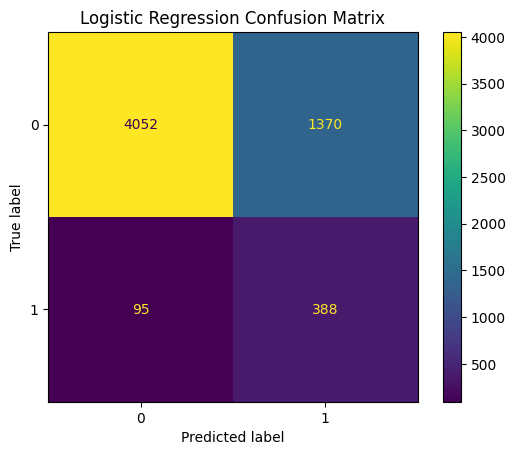

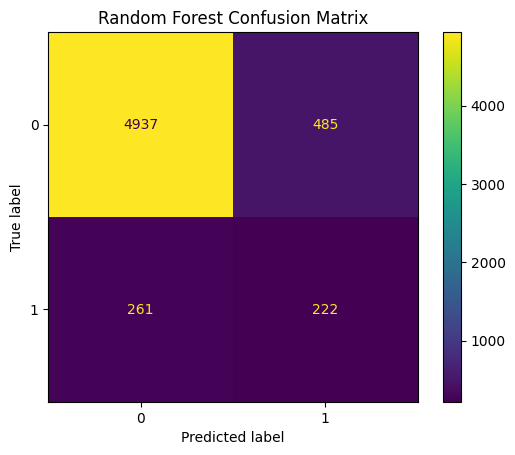

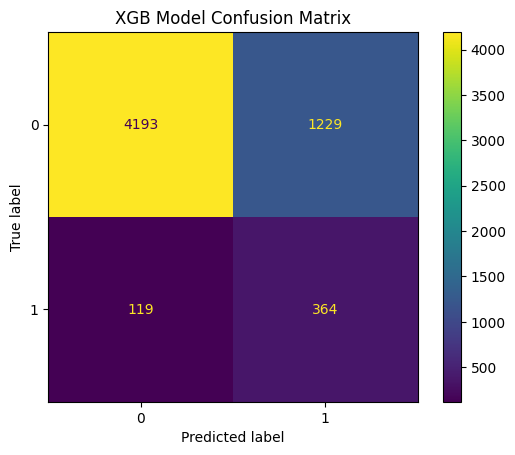

In [12]:
best_models_dict = dict(best_models)

# Confusion Matrices
for name, model in best_models_dict.items():
    disp = ConfusionMatrixDisplay.from_estimator(model, X_test, y_test)
    disp.ax_.set_title(f'{name} Confusion Matrix')
    plt.show()


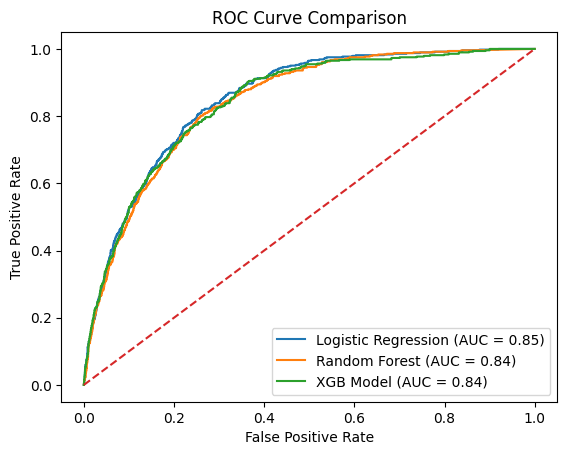

In [13]:
# ROC Curves
plt.figure()
for name, model in best_models_dict.items():
    y_prob = model.predict_proba(X_test)[:, 1]
    fpr, tpr, _ = roc_curve(y_test, y_prob)
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, label=f'{name} (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve Comparison')
plt.legend()
plt.show()